### Example: Non-uniform exponential model geometry


In [1]:
import os 
#os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax 
jax.config.update("jax_enable_x64", True)
import jax_sbgeom
import jax.numpy as jnp
%load_ext autoreload
%autoreload 2
import numpy as onp
import matplotlib.pyplot as plt
import pyvista as pv
from jax_sbgeom.jax_utils.utils import _mesh_to_pyvista_mesh

##### Setting up geometry

Selecting a particular coil and plasma set:

In [2]:
stell_i = -1
vmec_file = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/helias3_vmec.nc4",     "/home/tbogaarts/stellarator_paper/base_data/vmecs/helias4_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/helias5_vmec.nc4",     "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_vmec.nc4"][stell_i]
coil_file = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS3_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS4_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS5_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_coilset.h5"][stell_i]

We use a FluxSurfaceNoPhi, as this has the property that $\phi_{in} = \phi_{out}$ even beyond the LCFS (as required by FFTs). Furthermore, this creates a surface exactly the same as the original normal vector for constant $d$.

In [3]:
from jax_sbgeom.flux_surfaces import FluxSurfaceNormalExtendedConstantPhi, ToroidalExtent, FluxSurfaceFourierExtended, FluxSurfaceNormalExtendedNoPhi
from jax_sbgeom.coils         import CoilSet, DiscreteCoil, convert_to_fourier_coilset, RotationMinimizedFrame, FiniteSizeCoilSet
flux_surface = FluxSurfaceNormalExtendedNoPhi.from_hdf5(vmec_file)
def _get_discrete_coils(coil_file):
    import h5py
    with h5py.File(coil_file, 'r') as f:
        coil_data = jnp.array(f['Dataset1'])
    return CoilSet.from_list([DiscreteCoil.from_positions(coil_data[i]) for i in range(coil_data.shape[0])])
coilset         = _get_discrete_coils(coil_file)
fourier_coilset = convert_to_fourier_coilset(coilset)
fs_coilset      = FiniteSizeCoilSet.from_coilset(jax_sbgeom.coils.coilset.filter_coilset_phi(fourier_coilset, 0.0, 2 * jnp.pi / 2.0 / flux_surface.settings.nfp), RotationMinimizedFrame, 100)
mesh_coils      = jax_sbgeom.coils.mesh_coilset_surface(fs_coilset, 500, 0.2, 0.2)


## Coil Winding Surface

We first optimize the coil winding surfaces using the same arguments as in the stellarator paper:

In [4]:
cws_kwargs = {
            'ncoil_splines'       : 130,
            'ntor_splines'        : 205,
            'nphi_rt'             : 120,
            'ntheta_rt'           : 120,
            'smoothing'           : 1.0
        }
optimized_cws         = jax_sbgeom.coils.coil_winding_surface.create_optimized_coil_winding_surface(fourier_coilset, cws_kwargs['ncoil_splines'], cws_kwargs['ntor_splines'])
theta_d, phi_d, d_cws = jax_sbgeom.flux_surfaces.flux_surfaces_utilities.generate_thickness_matrix(flux_surface, optimized_cws, cws_kwargs['ntheta_rt'],cws_kwargs['nphi_rt'])
from scipy.ndimage import gaussian_filter
d_cws_smoothed = gaussian_filter(d_cws, sigma = cws_kwargs['smoothing'])

## Expontential model

We use an simple exponential model of all the layers. These coefficients are obtained by 1D simulations.


In [5]:
alpha   = 2.897
beta    = alpha
gamma   = 3.38
delta   = 6.2
epsilon = 8.06

epsilon = 6.0



zeta    = delta
blanket_dict = {
    "SOL" : {
        "decay" : 0.0,
        "d"     : 0.2,
        'resolution' : 1
    },
    "FirstWall" : {
        "decay" : alpha,        
        "d"     : 0.027,
        'resolution' : 1
    },
    "BreedingZone" : {
        "decay" : beta, 
        'resolution' : 5               
    },
    "BackSupportingStructure" : {
        "decay" : gamma,       
        "d"     : 0.385 ,
        'resolution' : 3
    },
    "VVWallFront" : {
        "decay" : delta,        
        "d"     : 0.1,
        'resolution' : 3
    },
    "VVShield" : {
        "decay" : epsilon,        
        'resolution' : 5
    },
    "VVWallBack" : {
        "decay" : zeta,    
        "d"     : 0.1,
        'resolution' : 5
    },
    "Void" : {
        'decay'      : 0.0,
        'resolution' : 7        
    }
}

exp_model_kwargs = {
            'phi_0'                   : 8e18,
            'phi_e'                   : 1e13,
            'maximum_dof_1_size'      : 1.0,
            'minimum_dof_2_size'      : 0.05,
            'smooth'                  : True,
            'smooth_sigma'            : 4,
            'dof_name_1'              : "BreedingZone",
            'dof_name_2'              : "VVShield"
        }
coil_thickness = 0.5

These coefficients can be used to analytically, at each position, maximize the breeder thickness while satisfying the fast flux constraint. Since we have 2 degrees of freedom (breeding zone thickness and shield thickness), this can be solved immediately:

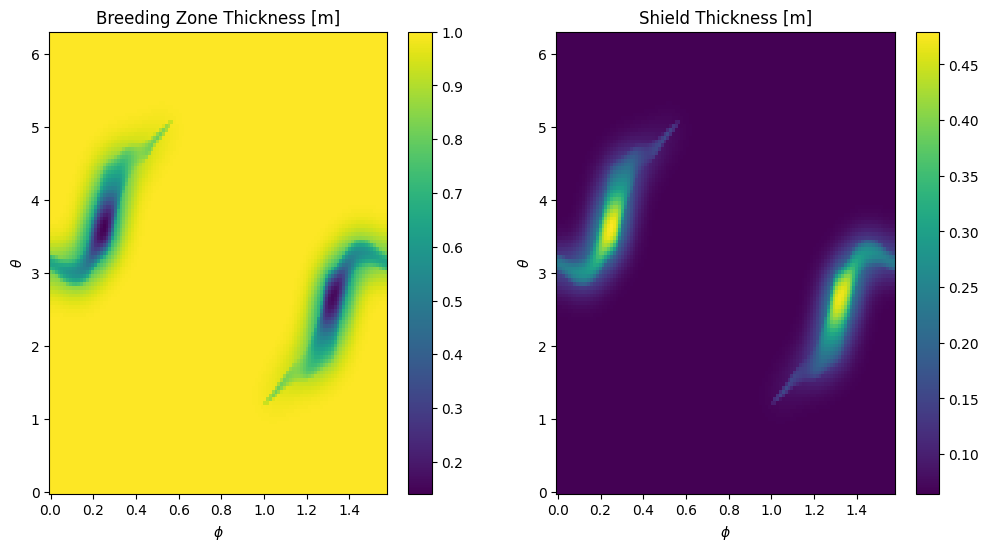

In [6]:

def find_bz_shield(blanket_dict, available_distance, phi_0, phi_e,  maximum_dof_1_size : float, minimum_dof_2_size : float, smooth = True, smooth_sigma = 4, dof_name_1 : str = "BreedingZone", dof_name_2 : str = "VVShield", void_key = "Void"):
    
    attenuation = onp.log10(phi_e / phi_0)    

    attenuation_without_bz_shield = sum([blanket_dict[layer]['decay'] * blanket_dict[layer]['d'] for layer in blanket_dict if (layer != dof_name_1 and layer != dof_name_2 and layer != void_key)])

    available_distance_for_bz_shield = available_distance - sum([blanket_dict[layer]['d'] for layer in blanket_dict if layer != dof_name_1 and layer != dof_name_2 and layer != void_key])
    
    required_attenuation_bz_shield = attenuation + attenuation_without_bz_shield
        
    available_bz = (required_attenuation_bz_shield + blanket_dict[dof_name_2]['decay'] * available_distance_for_bz_shield) / (blanket_dict[dof_name_2]['decay'] - blanket_dict[dof_name_1]['decay'])
    # if available_bz is greater than the allowable distance, it means that the shield needs to be 'negative' to satisfy the constraint. this just means that even if the 
    # entire volume is filled by the breeding zone, it is still below the constraint.

    # Now, the actual bz thickness is set to min(available_bz, maximum_dof_1_size) (we cap the bz thickness to 1m for practical reasons)    
    masked_bz =onp.minimum(available_bz, maximum_dof_1_size)# np.where(available_bz > maximum_dof_1_size, maximum_dof_1_size, available_bz)
    if smooth:        
        masked_bz = onp.minimum(gaussian_filter(masked_bz, sigma = smooth_sigma), masked_bz) # we can only smooth the minimum (otherwise we might violate the distance constraint)   
        
    required_shield_for_constraint = (required_attenuation_bz_shield + blanket_dict[dof_name_1]['decay'] * masked_bz) / ( -blanket_dict[dof_name_2]['decay'])        
    
    masked_shield =  onp.maximum(required_shield_for_constraint, minimum_dof_2_size)

    blanket_keys_no_void = [key for key in blanket_dict.keys() if key != void_key]

    if onp.any(masked_shield + masked_bz > available_distance_for_bz_shield + 0.1 * blanket_dict[blanket_keys_no_void[-1]]["d"]):        
        print("Warning: required shield + bz exceeds available distance by:")
        print(onp.max(masked_shield + masked_bz - available_distance_for_bz_shield))
    
    return masked_bz, masked_shield

d_bz, d_shield = find_bz_shield(blanket_dict, d_cws_smoothed - 0.5 * coil_thickness, **exp_model_kwargs)

fig, axs = plt.subplots(1,2, figsize = (12,6))
plt.sca(axs[0])
plt.title("Breeding Zone Thickness [m]")
plt.pcolormesh(phi_d, theta_d, d_bz)
plt.xlabel("$\\phi$")
plt.ylabel("$\\theta$")
plt.colorbar()
plt.sca(axs[1])
plt.title("Shield Thickness [m]")
plt.pcolormesh(phi_d, theta_d, d_shield)
plt.xlabel("$\\phi$")
plt.ylabel("$\\theta$")
_ = plt.colorbar()


We then create a new blanket dict which has those thicknesses present:

In [7]:

blanket_dict_copy = blanket_dict.copy()
blanket_dict_copy['BreedingZone']['d'] = d_bz
blanket_dict_copy['VVShield']['d']     = d_shield
d_values                               = [blanket_dict_copy[i]['d'] for i in blanket_dict_copy.keys() if i!='Void' ]
total_d_matrices                       = [jnp.full_like(d_bz, d) if isinstance(d,float) else d for d in d_values]
cumsum_d_matrices                      = jnp.cumsum(jnp.array(total_d_matrices), axis=0) # Thickness matrices for all layers
void_d_matrix                          = d_cws_smoothed -  cumsum_d_matrices[-1]

We use the same settings as in the stellarator paper

In [35]:
import equinox as eqx
from jax_sbgeom.flux_surfaces.flux_surfaces_base import _create_mpol_vector
@eqx.filter_jit
def stupid_thing(flux_surface):
    return _create_mpol_vector(flux_surface.settings.mpol, flux_surface.settings.ntor)

stupid_thing(flux_surface)

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int64)

In [38]:
params, static = eqx.partition(flux_surface, eqx.is_array)

In [40]:
static

FluxSurfaceNormalExtendedNoPhi(data=FluxSurfaceData(Rmnc=None, Zmns=None, mpol_vector=None, ntor_vector=None), settings=FluxSurfaceSettings(mpol=9, ntor=15, nfp=4))

In [30]:
from jax_sbgeom.flux_surfaces.convert_to_vmec import create_multiple_fourier_surface_extension_interp_equal_arclength, convert_to_different_mpol_ntor
fourier_ext_kwargs = {
            'nu_sample' : 120, 
            'nv_sample' : 104,
            'mpol': 20,
            'ntor': 30,
            'ntheta_arclength' : 300
        }         

Rmnc_t, Zmns_t, mpol_t, ntor_t, nfp_t = convert_to_different_mpol_ntor(*create_multiple_fourier_surface_extension_interp_equal_arclength(flux_surface, cumsum_d_matrices, fourier_ext_kwargs['nu_sample'], fourier_ext_kwargs['nv_sample'], fourier_ext_kwargs['ntheta_arclength']), 
                                                                       fourier_ext_kwargs['mpol'], fourier_ext_kwargs['ntor'])                                    

ValueError: Non-hashable static arguments are not supported. An error occurred while trying to hash an object of type <class 'jaxlib._jax.ArrayImpl'>, 60. The error was:
TypeError: unhashable type: 'jaxlib._jax.ArrayImpl'


In [29]:
from jax_sbgeom.flux_surfaces.convert_to_vmec import mpol_ntor_from_ntheta_nphi

jax.jit(mpol_ntor_from_ntheta_nphi, static_argnums=(0,1))(4,6)

(Array(2, dtype=int64, weak_type=True), Array(3, dtype=int64, weak_type=True))

In [9]:
create_multiple_fourier_surface_extension_interp_equal_arclength(flux_surface, cumsum_d_matrices, fourier_ext_kwargs['nu_sample'], fourier_ext_kwargs['nv_sample'], fourier_ext_kwargs['ntheta_arclength'])

(Array([[ 2.00029871e+01,  9.21876495e-01, -2.59012010e-01, ...,
          1.16662518e-08, -1.28012163e-08, -1.28472715e-08],
        [ 2.00003925e+01,  9.18837860e-01, -2.58857129e-01, ...,
          3.08843855e-08, -3.36017790e-08, -2.71547285e-08],
        [ 1.99456999e+01,  8.52364691e-01, -2.63953816e-01, ...,
         -3.17539296e-06,  2.29797665e-07, -1.73763224e-06],
        ...,
        [ 1.99163676e+01,  8.17949303e-01, -2.60565887e-01, ...,
          2.77307178e-06,  1.03715501e-05, -6.60452801e-06],
        [ 1.99093978e+01,  8.11150056e-01, -2.56240453e-01, ...,
          1.22165934e-05,  8.60412607e-06, -1.14896751e-05],
        [ 1.99049073e+01,  8.05863378e-01, -2.55815203e-01, ...,
          9.03947950e-06,  3.05440779e-06, -6.89635690e-06]],      dtype=float64),
 Array([[ 0.00000000e+00, -1.80736997e+00,  1.86443299e-02, ...,
          2.42539657e-08,  2.05770134e-08, -3.52930395e-23],
        [ 0.00000000e+00, -1.80512886e+00,  1.92375966e-02, ...,
         -3.275446

In [10]:
flux_surface_extension = jax_sbgeom.flux_surfaces.convert_to_vmec._create_fluxsurface_from_rmnc_zmns(Rmnc_t, Zmns_t, mpol_t, ntor_t, nfp_t, FluxSurfaceNormalExtendedNoPhi)
fs_new   = FluxSurfaceFourierExtended.from_flux_surface_and_extension(flux_surface, flux_surface_extension)

In [11]:
d_matrix_from_edge = jax_sbgeom.flux_surfaces.flux_surfaces_utilities.generate_thickness_matrix(flux_surface_extension, optimized_cws, cws_kwargs['ntheta_rt'],cws_kwargs['nphi_rt'])

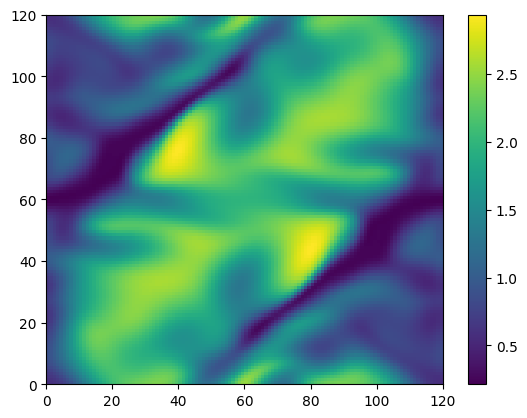

In [12]:
d_matrix_from_edge_smoothed = gaussian_filter(d_matrix_from_edge[2], sigma = cws_kwargs['smoothing'])
plt.pcolormesh(d_matrix_from_edge_smoothed)
plt.colorbar()

In [13]:
from jax_sbgeom.flux_surfaces.convert_to_vmec import create_fourier_surface_extension_interp
Rmnc_void, Zmns_void, _, _, _ = convert_to_different_mpol_ntor(*create_fourier_surface_extension_interp(flux_surface_extension, d_matrix_from_edge_smoothed, fourier_ext_kwargs['nu_sample'], fourier_ext_kwargs['nv_sample']), 
                                                                                                                fourier_ext_kwargs['mpol'], fourier_ext_kwargs['ntor'])                          

In [14]:
Rmnc_total = jnp.concatenate([Rmnc_t, Rmnc_void[jnp.newaxis, :]], axis=0)
Zmns_total = jnp.concatenate([Zmns_t, Zmns_void[jnp.newaxis, :]], axis=0)

flux_surface_extension_total = jax_sbgeom.flux_surfaces.convert_to_vmec._create_fluxsurface_from_rmnc_zmns(Rmnc_total, Zmns_total, fourier_ext_kwargs['mpol'], fourier_ext_kwargs['ntor'], nfp_t)
fs_total                     = FluxSurfaceFourierExtended.from_flux_surface_and_extension(flux_surface, flux_surface_extension_total)

In [15]:
n_surf_ext = fs_total.extension_flux_surface.data.Rmnc.shape[0]

ntheta = 55 
nphi   = 62

In [16]:
surfaces = [] 
for i in range(n_surf_ext  + 1):
    surfaces.append(jax_sbgeom.flux_surfaces.mesh_surface(fs_total, 1.0 + i, ToroidalExtent.half_module(fs_new), ntheta, nphi))

In [17]:
plotter = pv.Plotter()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'gray', 'white', 'cyan', 'magenta']
for s, i in enumerate(surfaces):
    mesh = _mesh_to_pyvista_mesh(*i)
    plotter.add_mesh(mesh, color = colors[s])

plotter.show()

Widget(value='<iframe src="http://localhost:40551/index.html?ui=P_0x702028171f10_0&reconnect=auto" class="pyvi…

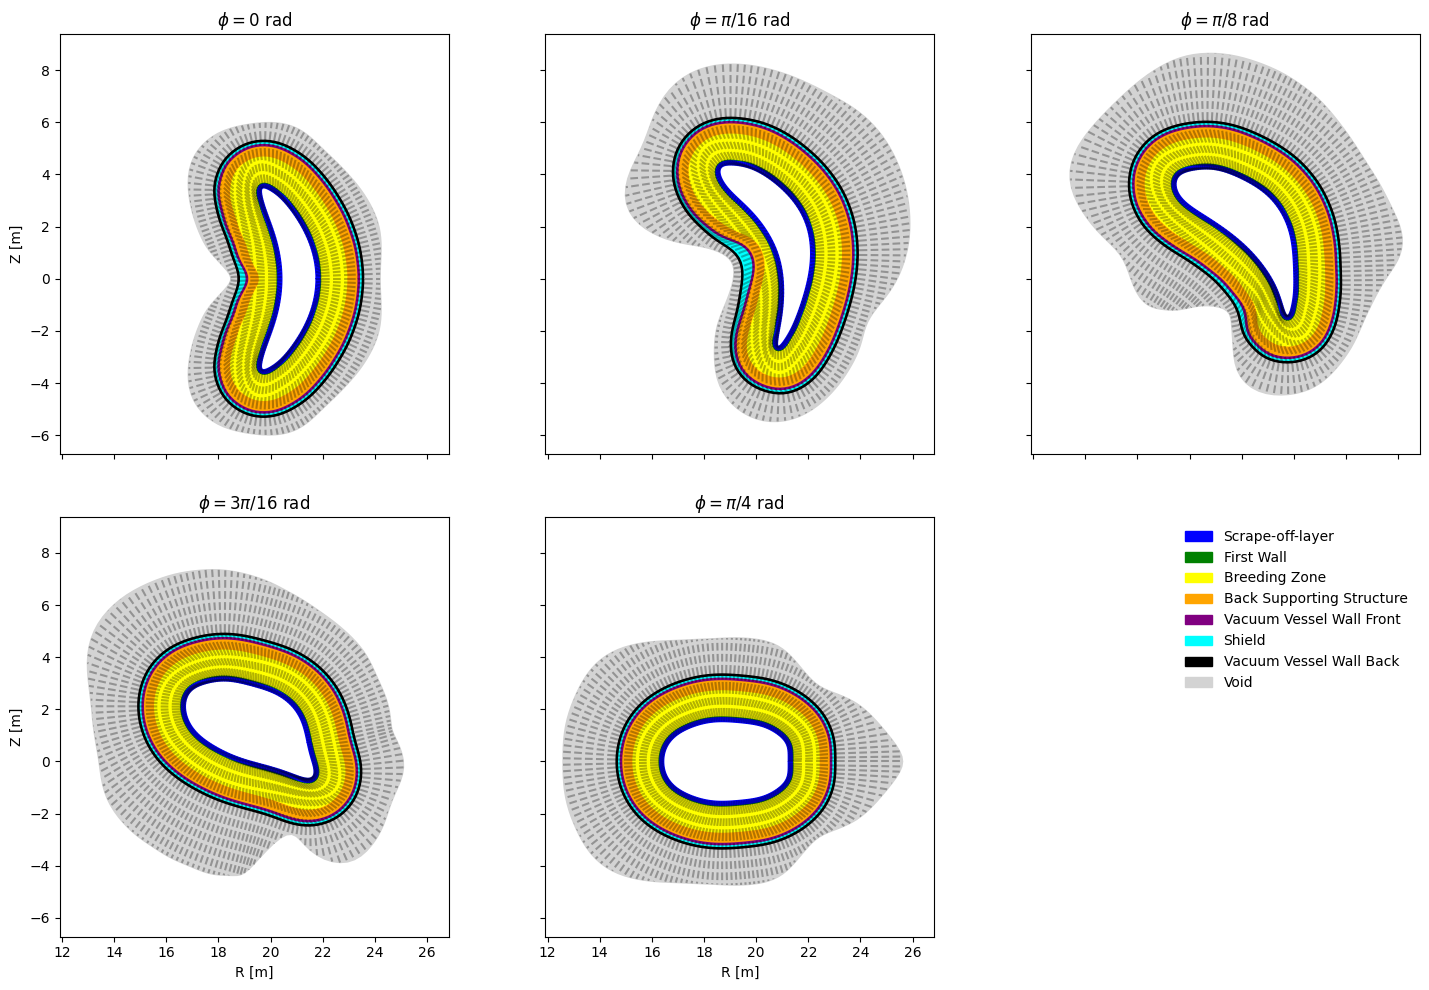

In [18]:

def plot_half_module_poloidal(no_phi_slices : int, fs_extended_base, key_list, ns = 160, plot_lines = True, base_plot_size = 5.0, width = None):
    from math import ceil
    from matplotlib.collections import LineCollection

    phi_slices = jnp.linspace(0, 2 * jnp.pi / fs_extended_base.settings.nfp/2.0, no_phi_slices, endpoint=True)
    colors = ['blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'black', 'lightgrey', 'brown', 'pink']

    no_surfaces= fs_extended_base.extension_flux_surface.data.Rmnc.shape[0]
    

    positions = [[fs_extended_base.cylindrical_position(1.0 + i, jnp.linspace(0, 2 * jnp.pi, ns), phi) for i in range(no_surfaces + 1)] for phi in phi_slices]
    #print(positions[-1][-1])

    pos_rs = jnp.array(positions).reshape(-1,3)
    ylims = jnp.array([pos_rs.min(axis=0)[0:2], pos_rs.max(axis=0)[0:2]])
    ylims = jnp.array([pos_rs.min(axis=0)[0:2], pos_rs.max(axis=0)[0:2]])

    margin = 0.05
    ymin = ylims[0] - margin * (ylims[1] - ylims[0])
    ymax = ylims[1] + margin * (ylims[1] - ylims[0])

    nrow = 2
    ncol = ceil(len(phi_slices)/2.0)

    if width is not None:
        base_plot_size = width / ncol

    fig, axs = plt.subplots(nrow, ncol, figsize=(base_plot_size * ncol, base_plot_size * nrow))
    for ax in axs.flat:
        ax.set_aspect('equal')    
        ax.set_xlim(ymin[0], ymax[0])
        ax.set_ylim(ymin[1], ymax[1])



    for idx, phi in enumerate(phi_slices):
        ax = axs.flat[idx]
        for i in range(no_surfaces):  # Fill between each pair of surfaces
        
            # Concatenate the boundary coordinates to form a closed polygon between two curves
            x = jnp.concatenate([positions[idx][i][:,0], positions[idx][i+1][::-1,0]])
            y = jnp.concatenate([positions[idx][i][:,1], positions[idx][i+1][::-1,1]])
            ax.fill(x, y, color=colors[i % len(colors)], alpha=1.0, label=key_list[i] if i < len(key_list) else "Outer Surface")

        if plot_lines:
            segments = []
            for i in range(no_surfaces):
                # shape (ns, 2, 2): pairs of points (x,y)
                segs = jnp.stack([positions[idx][i][:-1,:2], positions[idx][i+1][:-1,:2]], axis=1)

                segments.append(segs)
            segments = jnp.concatenate(segments, axis=0)

            lc = LineCollection(segments, colors="k", linestyles="--", alpha=0.3)
            ax.add_collection(lc)
            
        
        ax.set_aspect('equal')
        ax.set_title(f"$\\phi = {phi:.2f}$ rad")
        ax.set_xlim(ymin[0], ymax[0])
        ax.set_ylim(ymin[1], ymax[1])
        
        if idx == 0:
            ax.legend()
        if idx % ncol ==0:
            ax.set_ylabel('Z [m]')
        if idx  >= ncol * (nrow-1):
            ax.set_xlabel('R [m]')
    plt.tight_layout()
    return fig, axs

labels = [
        "Scrape-off-layer", "First Wall", "Breeding Zone", "Back Supporting Structure", "Vacuum Vessel Wall Front", "Shield", "Vacuum Vessel Wall Back", "Void"
    ]
fig, axs = plot_half_module_poloidal(5,  fs_total, labels)

axs.flat[-1].axis('off')
axs.flat[0].get_legend().remove()
axs.flat[-1].legend(*axs.flat[0].get_legend_handles_labels(), framealpha = 0.0)

axs.flat[0].set_title("$\\phi = 0$ rad")
axs.flat[1].set_title("$\\phi = \\pi /16 $ rad")
axs.flat[2].set_title("$\\phi = \\pi /8 $ rad")
axs.flat[3].set_title("$\\phi = 3\\pi /16 $ rad")
axs.flat[-2].set_title("$\\phi = \\pi/4$ rad")

axs.flat[0].set_xticklabels([])

axs.flat[1].set_xticklabels([])
axs.flat[1].set_yticklabels([])
axs.flat[2].set_xticklabels([])
axs.flat[2].set_yticklabels([])
axs.flat[4].set_yticklabels([])
_ = 0


In [19]:
from jax_sbgeom.interfaces import blanket_creation as bc

In [20]:
d_tuple = tuple([cumsum_d_matrices[i] for i in range(cumsum_d_matrices.shape[0])]+ [d_cws_smoothed])

In [21]:
resolutions = tuple([10] + [blanket_dict_copy[i]['resolution'] for i in blanket_dict_copy.keys()  if i != 'SOL'])

In [22]:

ntheta = 55 
nphi   = 62
layered_squid = bc.LayeredDiscreteBlanket(d_layers=d_tuple, n_theta= ntheta, n_phi=nphi, resolution_layers = resolutions, toroidal_extent= ToroidalExtent.half_module(fs_total))

In [23]:
tetrahedral_mesh = bc.mesh_tetrahedral_blanket(fs_total, layered_squid, 1)

In [24]:

#n_layers = domain_settings.no_radial_elements 
total_array_layers = jnp.zeros(tetrahedral_mesh[1].shape[0], dtype=int)

actual_layers = [0 for i in range(resolutions[0])] + sum([[i+1 for b in range(resolutions[i + 1])] for i in range(len(resolutions) - 1)], start=[])

for i in range(layered_squid.n_discrete_layers):
    total_array_layers = total_array_layers.at[layered_squid.layer_slice(i)].set(actual_layers[i])

In [25]:
plotter = pv.Plotter()
plotter.add_mesh(_mesh_to_pyvista_mesh(*tetrahedral_mesh), scalars = total_array_layers, opacity=1.0, show_edges=True, cmap = 'tab10')
plotter.add_mesh(_mesh_to_pyvista_mesh(*mesh_coils), color = 'white', opacity=1.0, show_edges=False)
plotter.show()

Widget(value='<iframe src="http://localhost:40551/index.html?ui=P_0x701f2cb95100_1&reconnect=auto" class="pyvi…

In [26]:
import stellsim 


Triangle Elements not compiled
